# Salary Prediction Model (R² > 0.8 Target)
This notebook trains multiple regression models on the jobs salaries dataset to achieve high R² performance.

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Load data
df = pd.read_csv('data/jobs_salaries_2023.csv')
df = df.dropna(subset=['salary_in_usd'])  # Drop rows with missing target
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000.0,EUR,85847.0,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000.0,USD,30000.0,US,100,US,S
2,2023,MI,CT,ML Engineer,25500.0,USD,25500.0,US,100,US,S
3,2023,SE,FT,Data Scientist,175000.0,USD,175000.0,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000.0,USD,120000.0,CA,100,CA,M


In [241]:
# Sort the dataset
df_sorted = df.sort_values(
    by=[
        "work_year",
        "job_title",
        "experience_level",
        "employment_type",
        "company_location",
    ],
    ascending=[True, True, True, True, True],
).reset_index(drop=True)

# Save to a new CSV file
df_sorted.to_csv("data/jobs_salaries_2023_sorted.csv", index=False)

print("Sorted dataset saved as data/jobs_salaries_2023_sorted.csv")

Sorted dataset saved as data/jobs_salaries_2023_sorted.csv


<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           1494 non-null   int64  
 1   experience_level    1494 non-null   object 
 2   employment_type     1494 non-null   object 
 3   job_title           1494 non-null   object 
 4   salary              1494 non-null   float64
 5   salary_currency     1494 non-null   object 
 6   salary_in_usd       1494 non-null   float64
 7   employee_residence  1494 non-null   object 
 8   remote_ratio        1494 non-null   int64  
 9   company_location    1494 non-null   object 
 10  company_size        1494 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 140.1+ KB
None
         work_year        salary  salary_in_usd  remote_ratio
count  1494.000000  1.494000e+03    1494.000000   1494.000000
mean   2022.078983  2.334004e+05  130933.809237     57.095047
std   

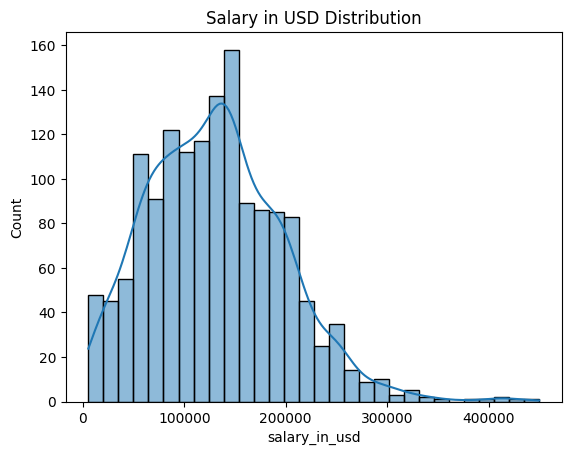

In [242]:
# Basic EDA
print(df.info())
print(df.describe())
sns.histplot(df['salary_in_usd'], bins=30, kde=True)
plt.title('Salary in USD Distribution')
plt.show()

In [243]:
# Count rows for each combination of the specified columns
counts = (
    df.groupby(
        [
            "work_year",
            "job_title",
            "experience_level",
            "employment_type",
        ]
    )
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Preview the result
counts.head(20)

,work_year,job_title,experience_level,employment_type,count
164,2022,Data Scientist,SE,FT,131
152,2022,Data Engineer,SE,FT,123
239,2023,Data Scientist,SE,FT,99
229,2023,Data Engineer,SE,FT,93
142,2022,Data Analyst,SE,FT,75
219,2023,Data Analyst,SE,FT,50
150,2022,Data Engineer,MI,FT,48
163,2022,Data Scientist,MI,FT,36
187,2022,Machine Learning Engineer,SE,FT,35
141,2022,Data Analyst,MI,FT,28


In [244]:
# Count rows for each combination
counts = (
    df.groupby(
        [
            "work_year",
            "job_title",
            "experience_level",
            "employment_type",
        ]
    )
    .size()
    .reset_index(name="count")
)

# Get the single combination with the highest count
top_combination = counts.sort_values(by="count", ascending=False).head(1)

# Filter dataset to keep only that combination
df_top_only = df.merge(
    top_combination[
        [
            "work_year",
            "job_title",
            "experience_level",
            "employment_type",
        ]
    ],
    on=[
        "work_year",
        "job_title",
        "experience_level",
        "employment_type",
    ],
    how="inner",
)

print(f"Most frequent combination: {top_combination.to_dict(orient='records')[0]}")
print(f"Rows kept: {len(df_top_only)}")

# Optional: Save to CSV
df_top_only.to_csv("jobs_salaries_2023_top_combination.csv", index=False)

df = df_top_only

Most frequent combination: {'work_year': 2022, 'job_title': 'Data Scientist', 'experience_level': 'SE', 'employment_type': 'FT', 'count': 131}
Rows kept: 131


In [245]:
# # Count number of samples per job_title, employment_type, and company_location
# job_emp_loc_counts = (
#     df.groupby(["job_title", "employment_type", "company_location"])
#     .size()
#     .reset_index(name="count")
# )

# # Sort by count (optional)
# job_emp_loc_counts = job_emp_loc_counts.sort_values(by="count", ascending=False)

# # Display the result (works in Jupyter / Colab)
# display(job_emp_loc_counts)

In [246]:
# # Count samples for each (job_title, employment_type, company_location) triplet
# triplet_counts = (
#     df.groupby(["job_title", "employment_type", "company_location"])
#     .size()
#     .reset_index(name="count")
# )

# # Keep only triplets with count >= 100
# valid_triplets = triplet_counts[triplet_counts["count"] >= 100][
#     ["job_title", "employment_type", "company_location"]
# ]

# # Merge back to filter original dataframe
# df = df.merge(
#     valid_triplets, on=["job_title", "employment_type", "company_location"], how="inner"
# )

# print(
#     "Remaining (job_title, employment_type, company_location) combinations after filtering:"
# )
# print(df.groupby(["job_title", "employment_type", "company_location"]).size())

In [247]:
# Select only chosen features
selected_features = [
    # "experience_level",
    # "employment_type",
    # "job_title",
    # "remote_ratio",
    "company_location",
    # "company_size",
]

X = df[selected_features]
y = df["salary_in_usd"]

categorical_cols = X.select_dtypes(include=["object"]).columns
print("Categorical:", categorical_cols.tolist())

numeric_cols = X.select_dtypes(exclude=["object"]).columns
print("Numeric:", numeric_cols.tolist())

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

Categorical: ['company_location']
Numeric: []


In [248]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)

    results[name] = r2
    print(f"{name} → R²: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# Find the best model by R²
best_model_name = max(results, key=results.get)
print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]:.4f}")

LinearRegression → R²: 0.0556 | MAE: 24522.47 | RMSE: 27088.51
RandomForest → R²: 0.0627 | MAE: 24282.26 | RMSE: 26985.86
GradientBoosting → R²: 0.0556 | MAE: 24522.39 | RMSE: 27088.47
XGBoost → R²: 0.0556 | MAE: 24522.46 | RMSE: 27088.51

Best model: RandomForest with R² = 0.0627


In [249]:
# Hyperparameter tuning for RandomForest (as example)
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

pipe = Pipeline([('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Params:', grid_search.best_params_)
print('Best CV R²:', grid_search.best_score_)

Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV R²: -0.022630610731052103


In [250]:
# Final evaluation
best_model = grid_search.best_estimator_
final_preds = best_model.predict(X_test)
print('Test R²:', r2_score(y_test, final_preds))
print("RMSE:", root_mean_squared_error(y_test, final_preds))

Test R²: 0.06269672727196207
RMSE: 26985.861340250613


In [ ]:
# Save model
import joblib
joblib.dump(best_model, 'models/best_salary_model.pkl')
print('Model saved to best_salary_model.pkl')

Model saved to best_salary_model.pkl


Exception ignored in: <function ResourceTracker.__del__ at 0x10b62e0c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10b2620c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versi